In [1]:
library(tidyverse)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
save_figs=TRUE

In [3]:
# theme with all the settings to make ggplot look nice
pub_theme <- function(text.size){
    theme(
        # text settings
        text = element_text(size = text.size),
        plot.title = element_text(hjust = 0.5),
        # background color
        panel.background = element_rect(fill = NA),
        # border color
        panel.border = element_blank(),
        axis.line = element_line(),
        # get rid of axis
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank(),
        # legend settings
        legend.background = element_blank()
    )
}

# Recordings

In [4]:
records <- read.csv('data_formatted/dance_recordings.csv')
df <- records %>% filter(dance_group != 'waltz')

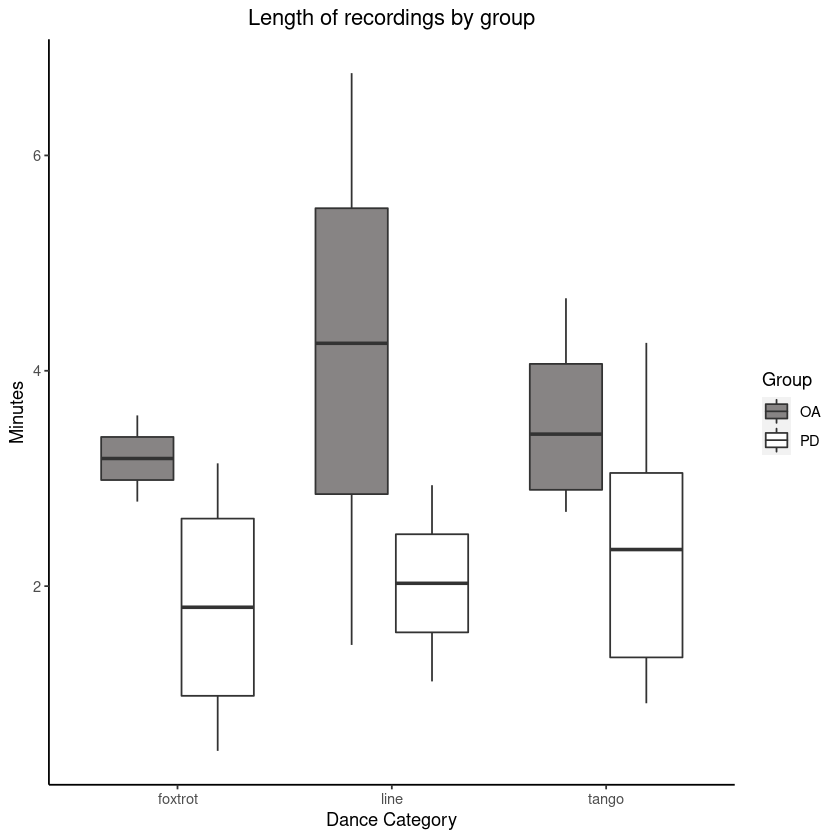

In [5]:
p <- ggplot(df, aes(x= dance_group, y=minutes, fill=group)) +
    geom_boxplot() +
    scale_fill_manual(values=c("#878484",  "#ffffff", "#EFF1ED"), labels=c('OA','PD'), name='Group') +
    xlab("Dance Category") +
    ylab('Minutes') +
    ggtitle("Length of recordings by group") + 
    pub_theme(11)
p

# Lag Values

In [6]:
tau <- read.csv('data_formatted/tau_values.csv')

In [7]:
tau.mean <- tau %>% group_by(group) %>% summarize(acf.avg = mean(acf), tau.avg = mean(lag))
tau.mean

group,acf.avg,tau.avg
<chr>,<dbl>,<dbl>
oa,0.04699655,753.7167
pd,0.02713452,660.4900


In [8]:
p.lag <- tau %>% 
    ggplot(aes(x=group, y=lag)) +
    geom_boxplot() +
    geom_point(x='oa', y=tau.mean[1,3] %>% pull, shape=8, size = 3) +
    geom_point(x='pd', y=tau.mean[2,3] %>% pull, shape=8, size = 3) +
    geom_jitter(alpha=0.25) +
    pub_theme(16) +
    # ggtitle('Delay numbers used for ApEn calculation') +
    xlab('Group') +
    ylab('Tau')

In [9]:
p.acf <- tau%>%
    ggplot(aes(x=group,y=acf)) +
    geom_boxplot() +
    geom_point(x='oa', y=tau.mean[1,2] %>% pull, shape=8, size = 3) +
    geom_point(x='pd', y=tau.mean[2,2] %>% pull, shape=8, size = 3) +
    geom_jitter(alpha=0.25) +
    pub_theme(16) +
    # ggtitle("ACF closest to 0 at the smallest lag value") +
    xlab('Group') +
    ylab('ACF')

In [10]:
p.grid <- plot_grid(p.lag, p.acf, labels='AUTO',ncol=2)

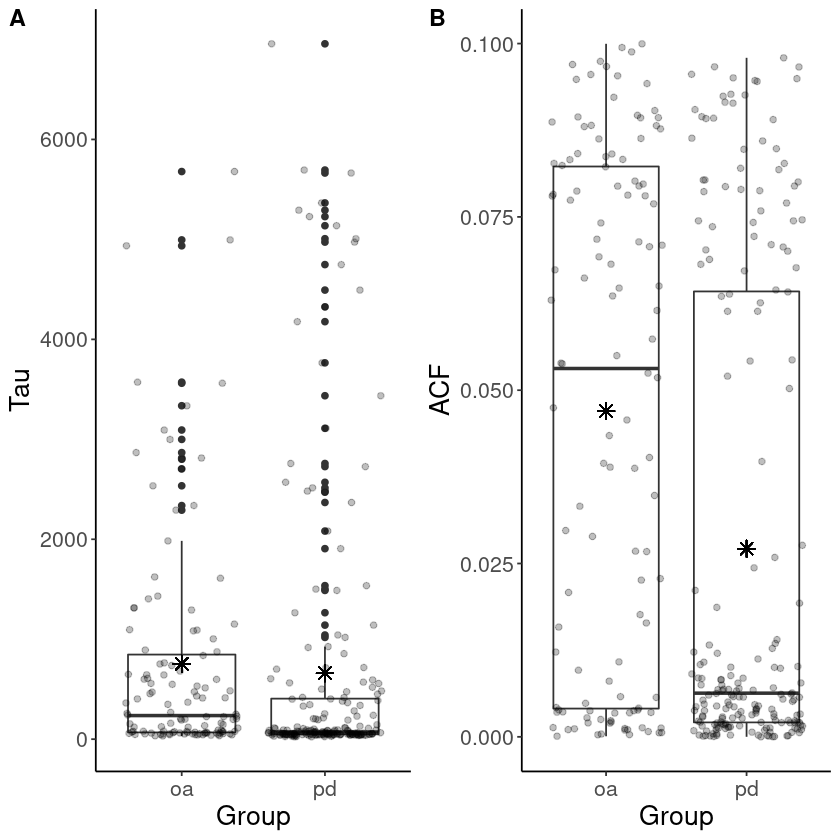

In [11]:
p.grid

# ACF Plots

See `04 stats.ipynb`, the `Graphing` heading. All ACF plots were collected into PDFs. Select ACF plots were saved with the "sample" prefix.

In [13]:
acf <- read.csv('data_formatted/all_acfs.csv')

# Tau Plot

In [14]:
dance.labs=c('Foxtrot','Line','Tango','Waltz')
names(dance.labs) = c('foxtrot','line','tango','waltz')

tau.plot <- ggplot(tau, aes(x=lag, y=acf)) +
    facet_grid(cols=vars(dance_group), labeller=labeller(dance_group=dance.labs)) +
    geom_point(aes(shape=group)) +
    scale_shape_manual('Group',values=c(3,17), label=c('OA','PD')) +
    # ggtitle('Tau values at each dance category') +
    xlab('Tau') +
    ylab('ACF Value') +
    pub_theme(16)

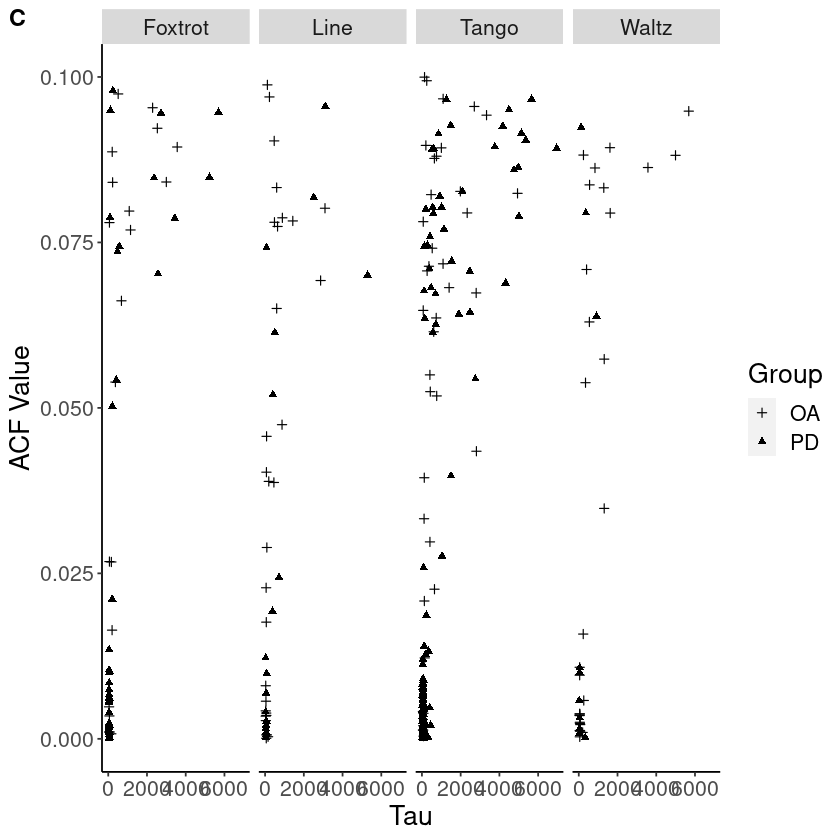

In [15]:
tau.plot <- plot_grid(tau.plot, labels='C')
tau.plot

In [16]:
library(gridExtra) # allows for uneven rows or columns in grid!


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




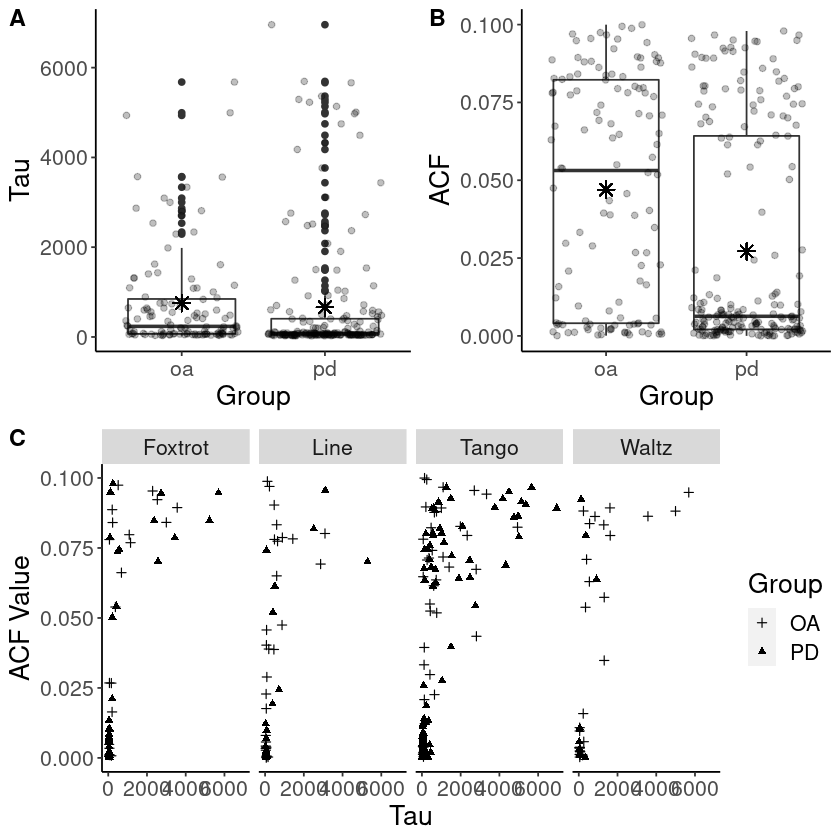

In [17]:
p.final <- grid.arrange(arrangeGrob(p.grid),tau.plot, nrow=2)

In [18]:
save_plot('figures/figure3.jpeg', p.final, nrow=2, dpi=1000, base_asp = 2.5)

In [19]:
# Helper functions to extract side and body movement
side.extract <- function(my_string){
    if(grepl('_lt', my_string)){
        return('left')
    } else {
        return('right')
    }
}

tau$side <- sapply(tau$measure, side.extract)
res <- tau %>% pull(measure) %>% str_match('-([a-z]+_)?l?r?t-([a-z]+)_')
tau$body_measure <- paste(res[,2],res[,3]) %>% str_replace(' ','')

In [20]:
body.labs <- c('Elbow Flexion','Hip Abduction', 'Hip Flexion', 'Hip Rotation', 'Knee Flexion')
names(body.labs) <- c('elbow_flexion','hip_abduction','hip_flexion','hip_rotation','knee_flexion')

side.labs <- c('OA','PD')
names(side.labs) <- c('oa','pd')

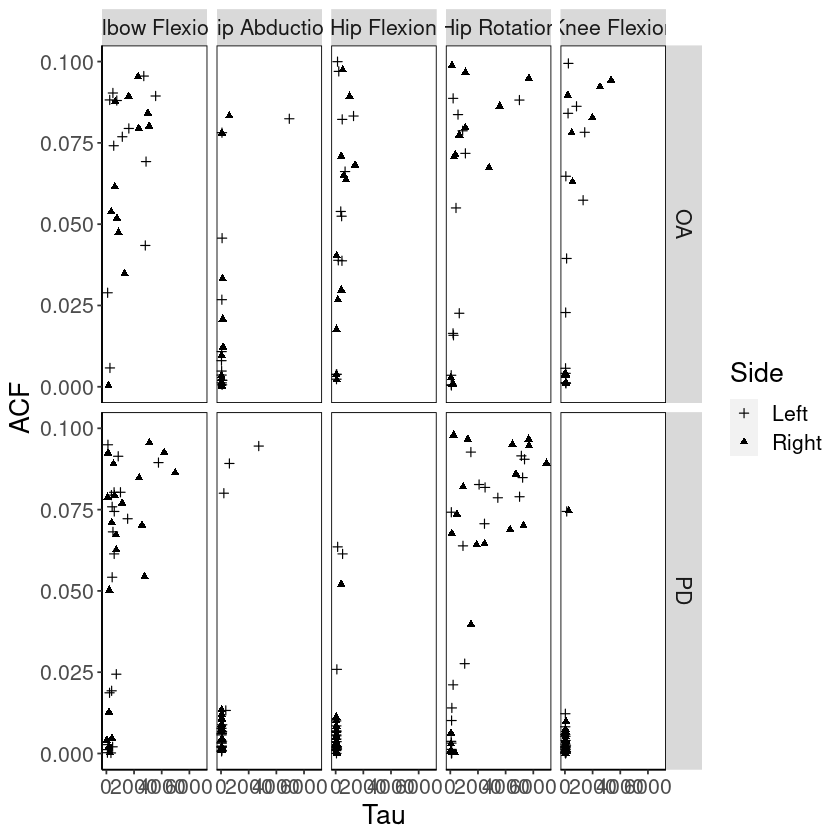

In [21]:
t <- tau %>%
    ggplot(aes(x=lag,y=acf)) +
    facet_grid(group~body_measure, labeller=labeller(body_measure=body.labs, group=side.labs)) +
    geom_point(aes(shape=side)) +
    scale_shape_manual('Side',values=c(3,17), label=c('Left','Right')) +
    xlab('Tau') +
    ylab('ACF') +
    # ggtitle('Tau values at each limb measure') +
    pub_theme(16) +
    theme(panel.background = element_rect(fill = NA, color = "black"))
t

In [22]:
save_plot('figures/figure2.jpeg', t, ncol=2, nrow=2, dpi=1000)

# Time Plots

In [24]:
joints <- read.csv('data_formatted/joints_labeled.csv')

In [28]:
head(joints)

,id,date,dance,time,joints.elbow_lt.flexion_.deg.,joints.hip_lt.flexion_.deg.,joints.hip_lt.abduction_.deg.,joints.hip_lt.rotation_ext_.deg.,joints.knee_lt.flexion_.deg.,joints.elbow_rt.flexion_.deg.,joints.hip_rt.flexion_.deg.,joints.hip_rt.abduction_.deg.,joints.hip_rt.rotation_ext_.deg.,joints.knee_rt.flexion_.deg.,unique_id,record,dance_group
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,pddancecon005,2018-11-15 13:47:00,electric slide,0.005,-0.458238,23.6274,-5.09624,11.6108,10.4402,47.5511,15.5307,2.78938,-8.75014,7.49284,pddancecon005_record01,record01,line
2,pddancecon005,2018-11-15 13:47:00,electric slide,0.015,-0.448757,23.8983,-5.16222,11.5693,10.9113,47.5581,15.7256,2.73978,-8.65008,7.85280,pddancecon005_record01,record01,line
3,pddancecon005,2018-11-15 13:47:00,electric slide,0.025,-0.422032,24.1600,-5.23020,11.5772,11.3694,47.5534,15.9043,2.69965,-8.53121,8.19385,pddancecon005_record01,record01,line
4,pddancecon005,2018-11-15 13:47:00,electric slide,0.035,-0.424552,24.4047,-5.29794,11.6034,11.8062,47.5432,16.0622,2.66440,-8.44873,8.50471,pddancecon005_record01,record01,line
5,pddancecon005,2018-11-15 13:47:00,electric slide,0.045,-0.429397,24.6267,-5.35555,11.5967,12.2208,47.5337,16.2195,2.63019,-8.36342,8.82541,pddancecon005_record01,record01,line
6,pddancecon005,2018-11-15 13:47:00,electric slide,0.055,-0.415986,24.8255,-5.39319,11.5527,12.6032,47.5106,16.3859,2.60468,-8.28477,9.14962,pddancecon005_record01,record01,line


In [29]:
joints.labs = c('Left knee flexion', 'Right knee flexion')
names(joints.labs) = c('joints.knee_lt.flexion_.deg.', 'joints.knee_rt.flexion_.deg.')

samples.lab = c('[PD] pddance003: record01','[OA] pddancecon003: record03')
names(samples.lab) = c('pddance003_record01','pddancecon003_record03')

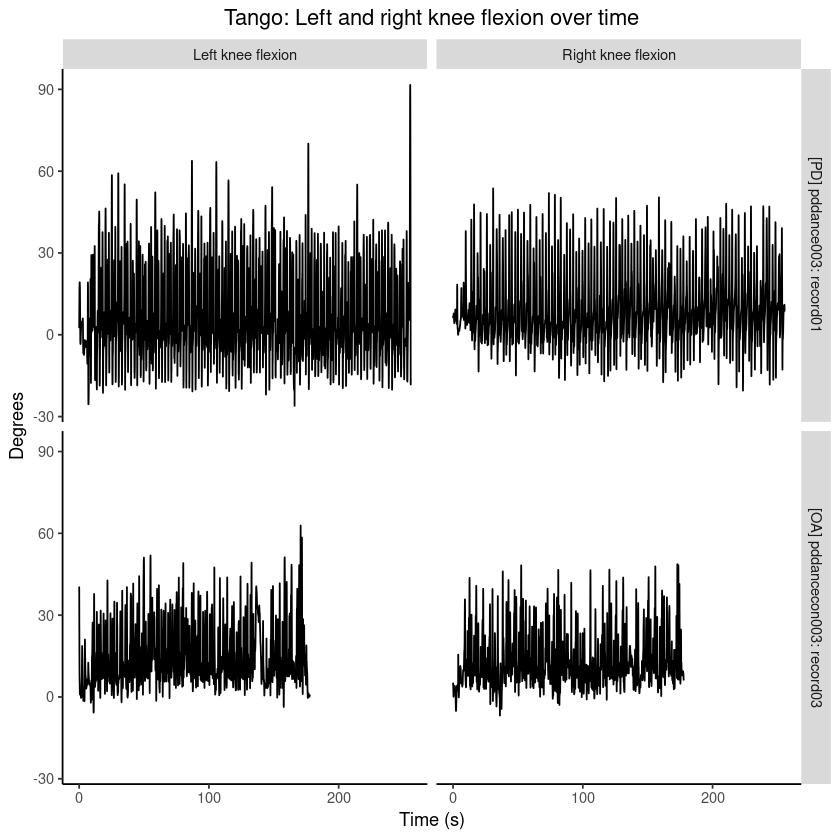

In [30]:
all.flex <- joints %>% 
    filter(dance_group == 'tango') %>% 
    select(c(unique_id, time, joints.knee_lt.flexion_.deg., joints.knee_rt.flexion_.deg.)) %>% 
    pivot_longer(cols = c(joints.knee_lt.flexion_.deg., joints.knee_rt.flexion_.deg.)) %>%
    filter(unique_id=='pddance003_record01' | unique_id=='pddancecon003_record03') %>%

    ggplot(aes(x=time, y=value, group=name)) +
        facet_grid(rows=vars(unique_id), cols=vars(name), labeller=labeller(name = joints.labs, unique_id = samples.lab)) +
        geom_line() + 
        ggtitle('Tango: Left and right knee flexion over time') +
        xlab('Time (s)') +
        ylab('Degrees') +
        pub_theme(11)

all.flex

# ApEn

See: `04 stats.ipynb`: Graphing heading.